In [1]:
from collections import Counter

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchinfo import summary
from torchmetrics.functional.image.ssim import structural_similarity_index_measure as ssim_func
from nn_zoo.datamodules import MNISTDataModule
from nn_zoo.models.components import DepthwiseSeparableConv2d, SelfAttention
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class RandomMask:
    def __init__(self, patch_size, mask_prob=0.5, mask_value=0):
        self.patch_size = (patch_size, patch_size)
        self.mask_prob = mask_prob
        self.mask_value = mask_value

    def __call__(self, x):
        batch_size, _, height, width = x.shape
        
        # Generate random start positions for each image in the batch
        start_pos = torch.randint(
            low=0, 
            high=min(height, width) - self.patch_size[0], 
            size=(batch_size, 2), 
            device=x.device
        )

        # Create a mask tensor initialized to ones
        mask = torch.ones_like(x)
        
        # Calculate the indices to apply the mask
        batch_indices = torch.arange(batch_size, device=x.device).view(batch_size, 1, 1)
        h_indices = torch.arange(self.patch_size[0], device=x.device).view(1, self.patch_size[0], 1)
        w_indices = torch.arange(self.patch_size[1], device=x.device).view(1, 1, self.patch_size[1])
        
        # Apply the mask in a vectorized manner
        mask[batch_indices, :, 
             start_pos[:, 0].view(-1, 1, 1) + h_indices, 
             start_pos[:, 1].view(-1, 1, 1) + w_indices] = self.mask_value
        
        # Calculate the number of images to leave unmasked
        num_to_unmask = int((1 - self.mask_prob) * batch_size)

        if num_to_unmask > 0:
            # Set the first num_to_unmask images to be fully unmasked (mask = 1)
            mask[:num_to_unmask, :, :, :] = 1

        return x * mask


dm = MNISTDataModule(
        data_dir="../../../data",
        dataset_params={
            "download": True,
            "transform": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((32, 32)),
                    torchvision.transforms.ToTensor(),
                ]
            )
        },
        loader_params={
            "batch_size": 128,
        },
    )

dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

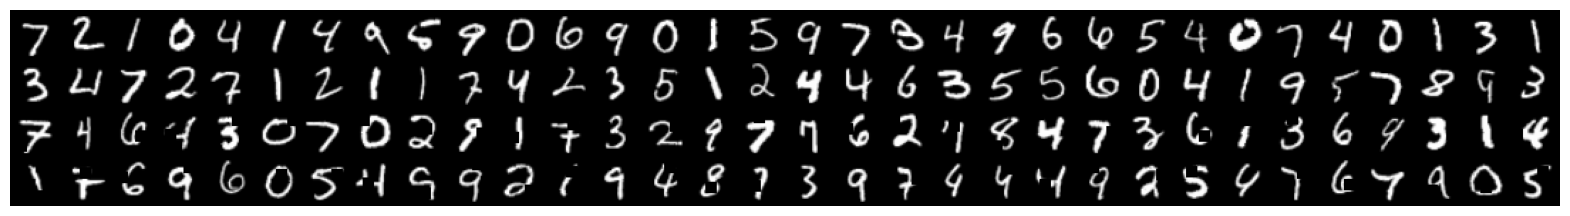

In [3]:
x, y = next(iter(val_loader))
x = RandomMask(8, 0.5, 0)(x)
grid = torchvision.utils.make_grid(x[:], nrow=32)

plt.figure(figsize=(20, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off");

### Create Model 

In [24]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(Block, self).__init__()
        self.layers = nn.ModuleList(
            [
                self._block(in_channels, out_channels)
                if i == 0
                else self._block(out_channels, out_channels)
                for i in range(num_layers)
            ]
        )

    def _block(self, in_channels: int, out_channels: int):
        return nn.Sequential(
            nn.GroupNorm(1, in_channels),
            nn.GELU(),
            DepthwiseSeparableConv2d(in_channels, out_channels, 3),
        )

    def forward(self, x):
        x = self.layers[0](x)
        for i, layer in enumerate(self.layers[1:]):
            x = layer(x) + x
        return x


class DownBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, depth: int):
        super(DownBlock, self).__init__(
            Block(in_channels * 4, out_channels, depth),
            # nn.MaxPool2d(2)
            nn.PixelUnshuffle(2),
        )


class UpBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, depth: int):
        super(UpBlock, self).__init__()
        self.block = nn.Sequential(
            nn.PixelShuffle(2),
            # nn.Upsample(scale_factor=2, mode="nearest"),
            Block(in_channels, out_channels * 4, depth),
        )

    def forward(self, x):
        return self.block(x)


class AutoEncoder(nn.Module):
    def __init__(self, width: int, depth: int):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            Block(1, width * 4, depth),
            DownBlock(width, width, depth),
            DownBlock(width, width, depth),
            DownBlock(width, width, depth),
            DownBlock(width, width, depth),
            DepthwiseSeparableConv2d(width * 4, width * 2, 1, padding=0),
        )
        self.proj_in = nn.Identity()
        self.vq = nn.Identity()
        # VectorQuantizer(width, 8, use_ema=True, decay=0.99, epsilon=1e-5)
        self.proj_out = nn.Identity()  # nn.Conv2d(width, width, 1)
        self.decoder = nn.Sequential(
            DepthwiseSeparableConv2d(width * 2, width * 4, 1, padding=0),
            UpBlock(width, width, depth),
            UpBlock(width, width, depth),
            UpBlock(width, width, depth),
            UpBlock(width, width, depth),
            Block(width * 4, 1, depth),
            nn.Sigmoid(),
        )

        # self.register_module(
        #     "lpips", lpips.LPIPS(net="squeeze", verbose=False, lpips=False)
        # )

    def encode(self, x):
        x = self.encoder(x)
        x = self.proj_in(x)
        return self.vq(x)  # quant_x, dict_loss, commit_loss, indices = self.vq(x)

    def decode(self, x):
        x = self.proj_out(x)
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    # @classmethod
    def loss(self, x, y):
        mse = F.mse_loss(x, y)
        bce = F.binary_cross_entropy((x + 1) / 2, (y + 1) / 2)
        psnr = 10 * (1 / mse).log10()
        ssim = ssim_func(x, y)
        # lpips = self.lpips(x.repeat(1, 3, 1, 1), y.repeat(1, 3, 1, 1)).mean()

        return {
            "loss": bce, # + lpips,
            "bce": bce,
            "mse": mse,
            "ssim": ssim,
            "psnr": psnr,
            # "lpips": lpips,
        }
    
model = AutoEncoder(4, 2).to("mps")
summary(model, input_size=(1, 1, 32, 32), depth=2, device="mps")

Layer (type:depth-idx)                                                 Output Shape              Param #
AutoEncoder                                                            [1, 1, 32, 32]            --
├─Sequential: 1-1                                                      [1, 8, 2, 2]              --
│    └─Block: 2-1                                                      [1, 16, 32, 32]           508
│    └─DownBlock: 2-2                                                  [1, 16, 16, 16]           328
│    └─DownBlock: 2-3                                                  [1, 16, 8, 8]             328
│    └─DownBlock: 2-4                                                  [1, 16, 4, 4]             328
│    └─DownBlock: 2-5                                                  [1, 16, 2, 2]             328
│    └─DepthwiseSeparableConv2d: 2-6                                   [1, 8, 2, 2]              168
├─Identity: 1-2                                                        [1, 8, 2, 2]      

In [25]:
@torch.no_grad()
def evaluate():
    model.eval()
    val_ssim = 0
    val_loss = 0
    
    for x, y in val_loader:
        x = x.to("mps")
        y_hat = model(x)
        loss = F.mse_loss(y_hat, x) + lpips.lpips(y_hat, x)

        val_loss += loss.item()
        val_ssim += ssim_func(y_hat, x).item()

    val_loss /= len(val_loader)
    val_ssim /= len(val_loader)

    return val_loss, val_ssim

evaluate()

(3.9625789817375474, 0.006132918745986646)

### Create LPIPS 

In [26]:
from lpips import LPIPS
    
lpips = LPIPS().to("mps")
lpips.eval()
print(lpips.lpips(torch.randn((4, 1, 32, 32), device="mps"), torch.randn((4, 1, 32, 32), device="mps")))

tensor([7.1202], device='mps:0', grad_fn=<ViewBackward0>)


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
if 'val_loss' not in locals() or 'val_ssim' not in locals():
    val_loss, val_ssim = evaluate()

for epoch in range(10):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", ncols=150, leave=True)

    val_loss, val_ssim = evaluate()
    
    for x, y in pbar:
        x = x.to("mps")
        optimizer.zero_grad()
        y_hat = model(x)
        loss = F.binary_cross_entropy(y_hat, x) + lpips.lpips(y_hat, x, linear=False) * 0.1
        loss.backward()
        optimizer.step()
        pbar.set_postfix_str(f"train_loss: {loss.item():.4f}, val_loss: {val_loss:.4f}, val_ssim: {val_ssim:.4f}")


Epoch 9: 100%|██████████████████████████████████████████████| 469/469 [02:57<00:00,  2.63it/s, train_loss: 0.1651, val_loss: 0.2319, val_ssim: 0.7631]


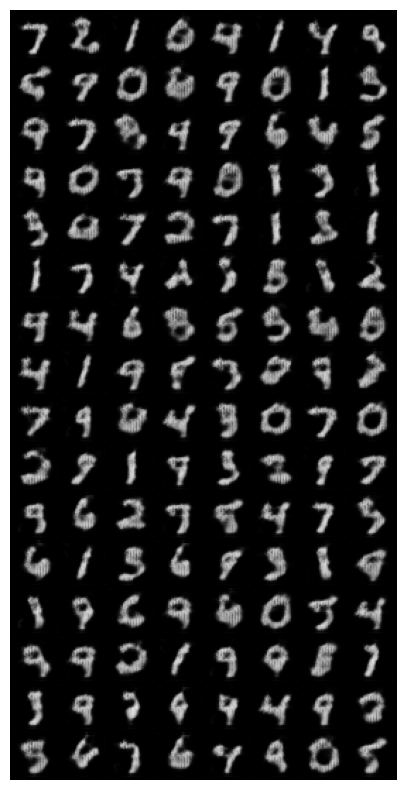

In [15]:
# plot reconstruction
x, y = next(iter(val_loader))
x = x.to("mps")

model.eval()
y_hat = model(x)
grid = torchvision.utils.make_grid(y_hat, nrow=8)

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off")
plt.show()

In [ ]:
with torch.no_grad():
    xs = []
    ys = []
    for x, y in tqdm(train_loader):
        x, y =  x.to("mps"), y.to("mps")
        y_hat = model(x)

        